In [1]:
# imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.segmentation import MeanIoU
import torchvision.transforms as transforms
from tqdm import tqdm

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Question 2

## Data Loader

In [8]:
class SegmentationDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image / 255.0
        image = (image - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        
        label = cv2.imread(label)
        label = label[:, :, 2]
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label

In [9]:
train_images_dir = "./dataset/train/images/"
train_labels_dir = "./dataset/train/labels/"
train_image_files = sorted([os.path.join(train_images_dir, f) for f in os.listdir(train_images_dir)])
train_label_files = sorted([os.path.join(train_labels_dir, f) for f in os.listdir(train_labels_dir)])

In [10]:

train_images, val_images, train_labels, val_labels = train_test_split(
    train_image_files, train_label_files, test_size=0.2, random_state=42
)

In [11]:
test_images_dir = "./dataset/test/images/"
test_labels_dir = "./dataset/test/labels/"
test_images = sorted([os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir)])
test_labels = sorted([os.path.join(test_labels_dir, f) for f in os.listdir(test_labels_dir)])

In [12]:
train_loader = DataLoader(
    SegmentationDataset(train_images, train_labels),
    batch_size=20,
    shuffle=True,
    num_workers=4
)
val_loader = DataLoader(
    SegmentationDataset(val_images, val_labels),
    batch_size=20,
    shuffle=False,
    num_workers=4
)
test_loader = DataLoader(
    SegmentationDataset(test_images, test_labels),
    batch_size=20,
    shuffle=False,
    num_workers=4
)

[ 0  1  2  3  5  6  7  8  9 10]


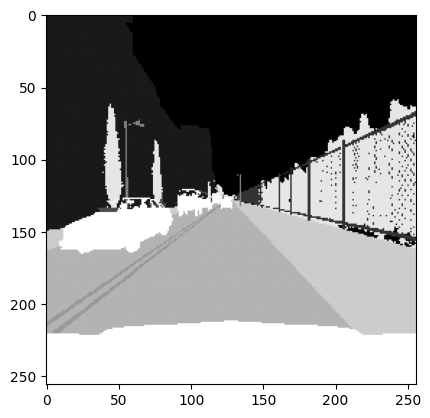

In [13]:
x = next(iter(test_loader))
print(np.unique(x[1][12]))
plt.imshow(x[1][12], cmap="gray")

## Models

In [14]:
class VanillaUNet(nn.Module):
    def __init__(self, num_classes):
        super(VanillaUNet, self).__init__()
        self.num_classes = num_classes
        self.encoder_maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder_convs = nn.ModuleList()
        self.decoder_trans = nn.ModuleList()
        self.decoder_convs = nn.ModuleList()
        
        self.encoder_convs.append(nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, padding=1), 
                               nn.ReLU(inplace=True),
                               nn.Conv2d(64, 64, kernel_size=3, padding=1),
                               nn.ReLU(inplace=True)))
        self.encoder_convs.append(nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1), 
                               nn.ReLU(inplace=True),
                               nn.Conv2d(128, 128, kernel_size=3, padding=1),
                               nn.ReLU(inplace=True)))
        self.encoder_convs.append(nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1), 
                               nn.ReLU(inplace=True),
                               nn.Conv2d(256, 256, kernel_size=3, padding=1),
                               nn.ReLU(inplace=True)))
        self.encoder_convs.append(nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, padding=1), 
                               nn.ReLU(inplace=True),
                               nn.Conv2d(512, 512, kernel_size=3, padding=1),
                               nn.ReLU(inplace=True)))
        
        self.bottleneck = nn.Sequential(nn.Conv2d(512, 1024, kernel_size=3, padding=1),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
                                         nn.ReLU(inplace=True))
        
        self.decoder_trans.append(nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2))
        self.decoder_convs.append(nn.Sequential(nn.Conv2d(1024, 512, kernel_size=3, padding=1),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                   nn.ReLU(inplace=True)))
        self.decoder_trans.append(nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2))
        self.decoder_convs.append(nn.Sequential(nn.Conv2d(512, 256, kernel_size=3, padding=1),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                   nn.ReLU(inplace=True)))
        self.decoder_trans.append(nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2))
        self.decoder_convs.append(nn.Sequential(nn.Conv2d(256, 128, kernel_size=3, padding=1),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(128, 128, kernel_size=3, padding=1),
                                   nn.ReLU(inplace=True)))
        self.decoder_trans.append(nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2))
        self.decoder_convs.append(nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                   nn.ReLU(inplace=True)))
        
        self.output_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        
    def forward(self, x):
        y = x
        enc_outs = []
        for enc in self.encoder_convs:
            y = enc(y)
            enc_outs.append(y)
            y = self.encoder_maxpool(y)
        
        y = self.bottleneck(y)
        
        i = -1
        for dec_t, dec in zip(self.decoder_trans, self.decoder_convs):
            y = dec_t(y)
            skip = enc_outs[i]
            i -= 1
            y = torch.cat((skip, y), dim=1)
            y = dec(y)
        
        y = self.output_conv(y)
        return y

In [15]:
class NoSkipUNet(nn.Module):
    def __init__(self, num_classes):
        super(NoSkipUNet, self).__init__()
        self.num_classes = num_classes
        self.encoder_maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder_convs = nn.ModuleList()
        self.decoder_trans = nn.ModuleList()
        
        self.encoder_convs.append(nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, padding=1), 
                               nn.ReLU(inplace=True),
                               nn.Conv2d(64, 64, kernel_size=3, padding=1),
                               nn.ReLU(inplace=True)))
        self.encoder_convs.append(nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1), 
                               nn.ReLU(inplace=True),
                               nn.Conv2d(128, 128, kernel_size=3, padding=1),
                               nn.ReLU(inplace=True)))
        self.encoder_convs.append(nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1), 
                               nn.ReLU(inplace=True),
                               nn.Conv2d(256, 256, kernel_size=3, padding=1),
                               nn.ReLU(inplace=True)))
        self.encoder_convs.append(nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, padding=1), 
                               nn.ReLU(inplace=True),
                               nn.Conv2d(512, 512, kernel_size=3, padding=1),
                               nn.ReLU(inplace=True)))
        
        self.bottleneck = nn.Sequential(nn.Conv2d(512, 1024, kernel_size=3, padding=1),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
                                         nn.ReLU(inplace=True))
        
        self.decoder_trans.append(nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2))
        self.decoder_trans.append(nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2))
        self.decoder_trans.append(nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2))
        self.decoder_trans.append(nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2))
        
        self.output_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        
    def forward(self, x):
        y = x
        for enc in self.encoder_convs:
            y = enc(y)
            y = self.encoder_maxpool(y)
        
        y = self.bottleneck(y)
        
        for dec_t in self.decoder_trans:
            y = dec_t(y)
        
        y = self.output_conv(y)
        return y

In [16]:
class ResidualUNet(nn.Module):
    def __init__(self, num_classes):
        super(ResidualUNet, self).__init__()
        self.num_classes = num_classes
        self.encoder_maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder_convs = nn.ModuleList()
        self.decoder_trans = nn.ModuleList()
        self.decoder_convs = nn.ModuleList()
        
        self.encoder_convs.append(nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, padding=1), 
                               nn.ReLU(inplace=True),
                               nn.Conv2d(64, 64, kernel_size=3, padding=1),
                               nn.ReLU(inplace=True)))
        self.encoder_convs.append(nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1), 
                               nn.ReLU(inplace=True),
                               nn.Conv2d(128, 128, kernel_size=3, padding=1),
                               nn.ReLU(inplace=True)))
        self.encoder_convs.append(nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1), 
                               nn.ReLU(inplace=True),
                               nn.Conv2d(256, 256, kernel_size=3, padding=1),
                               nn.ReLU(inplace=True)))
        self.encoder_convs.append(nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, padding=1), 
                               nn.ReLU(inplace=True),
                               nn.Conv2d(512, 512, kernel_size=3, padding=1),
                               nn.ReLU(inplace=True)))
        
        self.bottleneck = nn.Sequential(nn.Conv2d(512, 1024, kernel_size=3, padding=1),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
                                         nn.ReLU(inplace=True))
        
        self.decoder_trans.append(nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2))
        self.decoder_convs.append(nn.Sequential(nn.Conv2d(1024, 512, kernel_size=3, padding=1),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(512, 512, kernel_size=3, padding=1)))
        self.decoder_trans.append(nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2))
        self.decoder_convs.append(nn.Sequential(nn.Conv2d(512, 256, kernel_size=3, padding=1),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(256, 256, kernel_size=3, padding=1)))
        self.decoder_trans.append(nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2))
        self.decoder_convs.append(nn.Sequential(nn.Conv2d(256, 128, kernel_size=3, padding=1),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(128, 128, kernel_size=3, padding=1)))
        self.decoder_trans.append(nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2))
        self.decoder_convs.append(nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(64, 64, kernel_size=3, padding=1)))
        
        self.output_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        
    def forward(self, x):
        y = x
        enc_outs = []
        for enc in self.encoder_convs:
            y = enc(y)
            enc_outs.append(y)
            y = self.encoder_maxpool(y)
        
        y = self.bottleneck(y)
        
        i = -1
        for dec_t, dec in zip(self.decoder_trans, self.decoder_convs):
            y = dec_t(y)
            in_y = y
            skip = enc_outs[i]
            i -= 1
            y = torch.cat((skip, y), dim=1)
            y = dec(y)
            y = y + in_y
            y = nn.ReLU(inplace=True)(y)
        
        y = self.output_conv(y)
        return y

In [17]:
class GatedUNet(nn.Module):
    def __init__(self, num_classes):
        super(GatedUNet, self).__init__()
        self.num_classes = num_classes
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder_maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder_convs = nn.ModuleList()
        self.decoder_trans = nn.ModuleList()
        self.decoder_convs = nn.ModuleList()
        
        self.encoder_convs.append(nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, padding=1), 
                               nn.ReLU(inplace=True),
                               nn.Conv2d(64, 64, kernel_size=3, padding=1),
                               nn.ReLU(inplace=True)))
        self.encoder_convs.append(nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1), 
                               nn.ReLU(inplace=True),
                               nn.Conv2d(128, 128, kernel_size=3, padding=1),
                               nn.ReLU(inplace=True)))
        self.encoder_convs.append(nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1), 
                               nn.ReLU(inplace=True),
                               nn.Conv2d(256, 256, kernel_size=3, padding=1),
                               nn.ReLU(inplace=True)))
        self.encoder_convs.append(nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, padding=1), 
                               nn.ReLU(inplace=True),
                               nn.Conv2d(512, 512, kernel_size=3, padding=1),
                               nn.ReLU(inplace=True)))
        
        self.bottleneck = nn.Sequential(nn.Conv2d(512, 1024, kernel_size=3, padding=1),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
                                         nn.ReLU(inplace=True))
        
        self.decoder_trans.append(nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2))
        self.decoder_convs.append(nn.Sequential(nn.Conv2d(1024, 512, kernel_size=3, padding=1),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(512, 512, kernel_size=3, padding=1)))
        self.decoder_trans.append(nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2))
        self.decoder_convs.append(nn.Sequential(nn.Conv2d(512, 256, kernel_size=3, padding=1),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(256, 256, kernel_size=3, padding=1)))
        self.decoder_trans.append(nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2))
        self.decoder_convs.append(nn.Sequential(nn.Conv2d(256, 128, kernel_size=3, padding=1),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(128, 128, kernel_size=3, padding=1)))
        self.decoder_trans.append(nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2))
        self.decoder_convs.append(nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(64, 64, kernel_size=3, padding=1)))
        
        self.output_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        
    def gate(self, x, skip):
        inp = skip
        x = nn.Conv2d(x.shape[1], x.shape[1] // 2, kernel_size=1).to(self.device)(x)
        skip = nn.Conv2d(skip.shape[1], skip.shape[1] // 2, kernel_size=1).to(self.device)(skip)
        y = x + skip
        y = nn.ReLU(inplace=True).to(self.device)(y)
        y = nn.Conv2d(y.shape[1], 1, kernel_size=1).to(self.device)(y)
        y = nn.Sigmoid().to(self.device)(y)
        alpha = 1
        y = y * alpha * inp
        return y
        
    def forward(self, x):
        y = x
        enc_outs = []
        for enc in self.encoder_convs:
            y = enc(y)
            enc_outs.append(y)
            y = self.encoder_maxpool(y)
        
        y = self.bottleneck(y)
        
        i = -1
        for dec_t, dec in zip(self.decoder_trans, self.decoder_convs):
            y = dec_t(y)
            in_y = y
            skip = enc_outs[i]
            i -= 1
            skip = self.gate(y, skip)
            y = torch.cat((skip, y), dim=1)
            y = dec(y)
            y = y + in_y
            y = nn.ReLU(inplace=True)(y)
        
        y = self.output_conv(y)
        return y

## Train, Test, Plot, Visualize Functions

In [18]:
def train(model, train_loader, val_loader, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    train_losses = []
    val_losses = []
    train_mious = []
    val_mious = []

    best_val_miou = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_miou = 0.0
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for images, labels in tqdm(train_loader, desc="Training", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            outputs = F.interpolate(outputs, size=labels.shape[1:], mode="bilinear")
            preds = torch.argmax(outputs, dim=1)
            miou = MeanIoU(num_classes=model.num_classes).to(device)
            miou.update(preds, labels)
            miou = miou.compute()
            train_miou += miou.item()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_miou /= len(train_loader)
        train_losses.append(train_loss)
        train_mious.append(train_miou)

        model.eval()
        val_loss = 0.0
        val_miou = 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                miou = MeanIoU(num_classes=model.num_classes).to(device)
                miou.update(preds, labels)
                miou = miou.compute()
                val_miou += miou.item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_miou /= len(val_loader)
        val_losses.append(val_loss)
        val_mious.append(val_miou)

        if val_miou > best_val_miou:
            best_val_miou = val_miou
            best_model_state = model.state_dict()

        print(f"Train Loss: {train_loss:.4f}, Train mIoU: {train_miou:.4f}, Val Loss: {val_loss:.4f}, Val mIoU: {val_miou:.4f}")

    return train_losses, train_mious, val_losses, val_mious, best_model_state

In [19]:
def test(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    test_miou = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            miou = MeanIoU(num_classes=model.num_classes).to(device)
            miou.update(preds, labels)
            miou = miou.compute()
            test_miou += miou.item()
    test_miou /= len(test_loader)
    print(f"Test mIoU: {test_miou:.4f}")

In [20]:
def train_graphs(train_losses, train_mious, val_losses, val_mious):
    plt.figure(figsize=(12, 5))
    plt.suptitle('Training and Validation Metrics', fontsize=16)
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_mious, label='Train mIoU')
    plt.plot(val_mious, label='Validation mIoU')
    plt.xlabel('Epochs')
    plt.ylabel('mIoU')
    plt.legend()
    plt.title('mIoU vs Epochs')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

In [21]:
def visualize_model_results(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    axes = axes.flatten()

    with torch.no_grad():
        i = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            preds = preds.cpu().numpy()
            labels = labels.cpu().numpy()
            images = images.cpu().numpy()
            image = images[0].transpose(1, 2, 0)
            image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
            image = np.clip(image, 0, 1)

            axes[i].imshow(image)
            axes[i].set_title("Original Image")
            axes[i].axis('off')

            axes[i + 5].imshow(labels[0], cmap='gray')
            axes[i + 5].set_title("Ground Truth")
            axes[i + 5].axis('off')

            axes[i + 10].imshow(preds[0], cmap='gray')
            axes[i + 10].set_title("Prediction")
            axes[i + 10].axis('off')

            i += 1
            if i >= 5:
                break

    plt.tight_layout()
    plt.show()

## Vanilla U-Net

In [22]:
model = VanillaUNet(13)
train_losses, train_mious, val_losses, val_mious, best_model_state = train(model, train_loader, val_loader, 50)
torch.save(model.state_dict(), "vanilla_unet.pth")

Epoch 1/50


Train Loss: 1.7617, Train mIoU: 0.3492, Val Loss: 1.1843, Val mIoU: 0.4490
Epoch 2/50


Train Loss: 0.9276, Train mIoU: 0.5435, Val Loss: 0.7554, Val mIoU: 0.5898
Epoch 3/50


Train Loss: 0.6801, Train mIoU: 0.6088, Val Loss: 0.6197, Val mIoU: 0.6378
Epoch 4/50


Train Loss: 0.5692, Train mIoU: 0.6465, Val Loss: 0.5262, Val mIoU: 0.6710
Epoch 5/50


Train Loss: 0.4906, Train mIoU: 0.6827, Val Loss: 0.4513, Val mIoU: 0.7072
Epoch 6/50


Train Loss: 0.4514, Train mIoU: 0.7043, Val Loss: 0.4291, Val mIoU: 0.7168
Epoch 7/50


Train Loss: 0.3971, Train mIoU: 0.7335, Val Loss: 0.3840, Val mIoU: 0.7439
Epoch 8/50


Train Loss: 0.3589, Train mIoU: 0.7533, Val Loss: 0.4024, Val mIoU: 0.7399
Epoch 9/50


Train Loss: 0.3408, Train mIoU: 0.7610, Val Loss: 0.3231, Val mIoU: 0.7721
Epoch 10/50


Train Loss: 0.3123, Train mIoU: 0.7728, Val Loss: 0.3068, Val mIoU: 0.7792
Epoch 11/50


Train Loss: 0.2949, Train mIoU: 0.7783, Val Loss: 0.2877, Val mIoU: 0.7865
Epoch 12/50


Train Loss: 0.2738, Train mIoU: 0.7866, Val Loss: 0.2694, Val mIoU: 0.7927
Epoch 13/50


Train Loss: 0.2594, Train mIoU: 0.7923, Val Loss: 0.2553, Val mIoU: 0.7986
Epoch 14/50


Train Loss: 0.2426, Train mIoU: 0.7987, Val Loss: 0.2402, Val mIoU: 0.8026
Epoch 15/50


Train Loss: 0.2298, Train mIoU: 0.8036, Val Loss: 0.2319, Val mIoU: 0.8074
Epoch 16/50


Train Loss: 0.2177, Train mIoU: 0.8088, Val Loss: 0.2179, Val mIoU: 0.8151
Epoch 17/50


Train Loss: 0.2064, Train mIoU: 0.8138, Val Loss: 0.2053, Val mIoU: 0.8170
Epoch 18/50


Train Loss: 0.1955, Train mIoU: 0.8187, Val Loss: 0.2016, Val mIoU: 0.8231
Epoch 19/50


Train Loss: 0.1881, Train mIoU: 0.8227, Val Loss: 0.1903, Val mIoU: 0.8277
Epoch 20/50


Train Loss: 0.1754, Train mIoU: 0.8296, Val Loss: 0.1834, Val mIoU: 0.8316
Epoch 21/50


Train Loss: 0.1752, Train mIoU: 0.8289, Val Loss: 0.1816, Val mIoU: 0.8305
Epoch 22/50


Train Loss: 0.1651, Train mIoU: 0.8347, Val Loss: 0.1726, Val mIoU: 0.8396
Epoch 23/50


Train Loss: 0.1560, Train mIoU: 0.8409, Val Loss: 0.1641, Val mIoU: 0.8454
Epoch 24/50


Train Loss: 0.1512, Train mIoU: 0.8449, Val Loss: 0.1570, Val mIoU: 0.8498
Epoch 25/50


Train Loss: 0.1437, Train mIoU: 0.8497, Val Loss: 0.1540, Val mIoU: 0.8522
Epoch 26/50


Train Loss: 0.1376, Train mIoU: 0.8537, Val Loss: 0.1501, Val mIoU: 0.8513
Epoch 27/50


Train Loss: 0.1355, Train mIoU: 0.8549, Val Loss: 0.1459, Val mIoU: 0.8556
Epoch 28/50


Train Loss: 0.1345, Train mIoU: 0.8559, Val Loss: 0.1447, Val mIoU: 0.8591
Epoch 29/50


Train Loss: 0.1267, Train mIoU: 0.8608, Val Loss: 0.1387, Val mIoU: 0.8592
Epoch 30/50


Train Loss: 0.1228, Train mIoU: 0.8631, Val Loss: 0.1341, Val mIoU: 0.8639
Epoch 31/50


Train Loss: 0.1192, Train mIoU: 0.8650, Val Loss: 0.1391, Val mIoU: 0.8609
Epoch 32/50


Train Loss: 0.1191, Train mIoU: 0.8651, Val Loss: 0.1322, Val mIoU: 0.8646
Epoch 33/50


Train Loss: 0.1154, Train mIoU: 0.8676, Val Loss: 0.1308, Val mIoU: 0.8637
Epoch 34/50


Train Loss: 0.1116, Train mIoU: 0.8697, Val Loss: 0.1262, Val mIoU: 0.8676
Epoch 35/50


Train Loss: 0.1097, Train mIoU: 0.8710, Val Loss: 0.1252, Val mIoU: 0.8681
Epoch 36/50


Train Loss: 0.1075, Train mIoU: 0.8719, Val Loss: 0.1249, Val mIoU: 0.8687
Epoch 37/50


Train Loss: 0.1059, Train mIoU: 0.8729, Val Loss: 0.1238, Val mIoU: 0.8695
Epoch 38/50


Train Loss: 0.1055, Train mIoU: 0.8729, Val Loss: 0.1206, Val mIoU: 0.8712
Epoch 39/50


Train Loss: 0.1023, Train mIoU: 0.8744, Val Loss: 0.1188, Val mIoU: 0.8714
Epoch 40/50


Train Loss: 0.1007, Train mIoU: 0.8756, Val Loss: 0.1184, Val mIoU: 0.8724
Epoch 41/50


Train Loss: 0.0976, Train mIoU: 0.8772, Val Loss: 0.1144, Val mIoU: 0.8751
Epoch 42/50


Train Loss: 0.0971, Train mIoU: 0.8776, Val Loss: 0.1233, Val mIoU: 0.8693
Epoch 43/50


Train Loss: 0.0968, Train mIoU: 0.8777, Val Loss: 0.1163, Val mIoU: 0.8737
Epoch 44/50


Train Loss: 0.0952, Train mIoU: 0.8785, Val Loss: 0.1197, Val mIoU: 0.8718
Epoch 45/50


Train Loss: 0.0921, Train mIoU: 0.8802, Val Loss: 0.1136, Val mIoU: 0.8754
Epoch 46/50


Train Loss: 0.0901, Train mIoU: 0.8814, Val Loss: 0.1103, Val mIoU: 0.8768
Epoch 47/50


Train Loss: 0.0907, Train mIoU: 0.8813, Val Loss: 0.1124, Val mIoU: 0.8753
Epoch 48/50


Train Loss: 0.0894, Train mIoU: 0.8818, Val Loss: 0.1098, Val mIoU: 0.8776
Epoch 49/50


Train Loss: 0.0899, Train mIoU: 0.8810, Val Loss: 0.1117, Val mIoU: 0.8770
Epoch 50/50


Train Loss: 0.0883, Train mIoU: 0.8821, Val Loss: 0.1093, Val mIoU: 0.8779


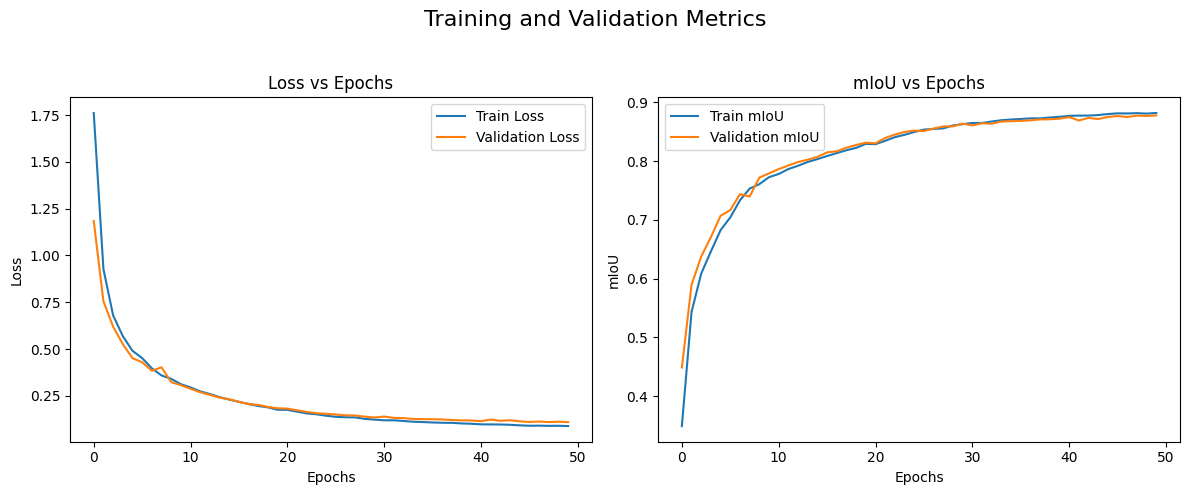

Test mIoU: 0.8707


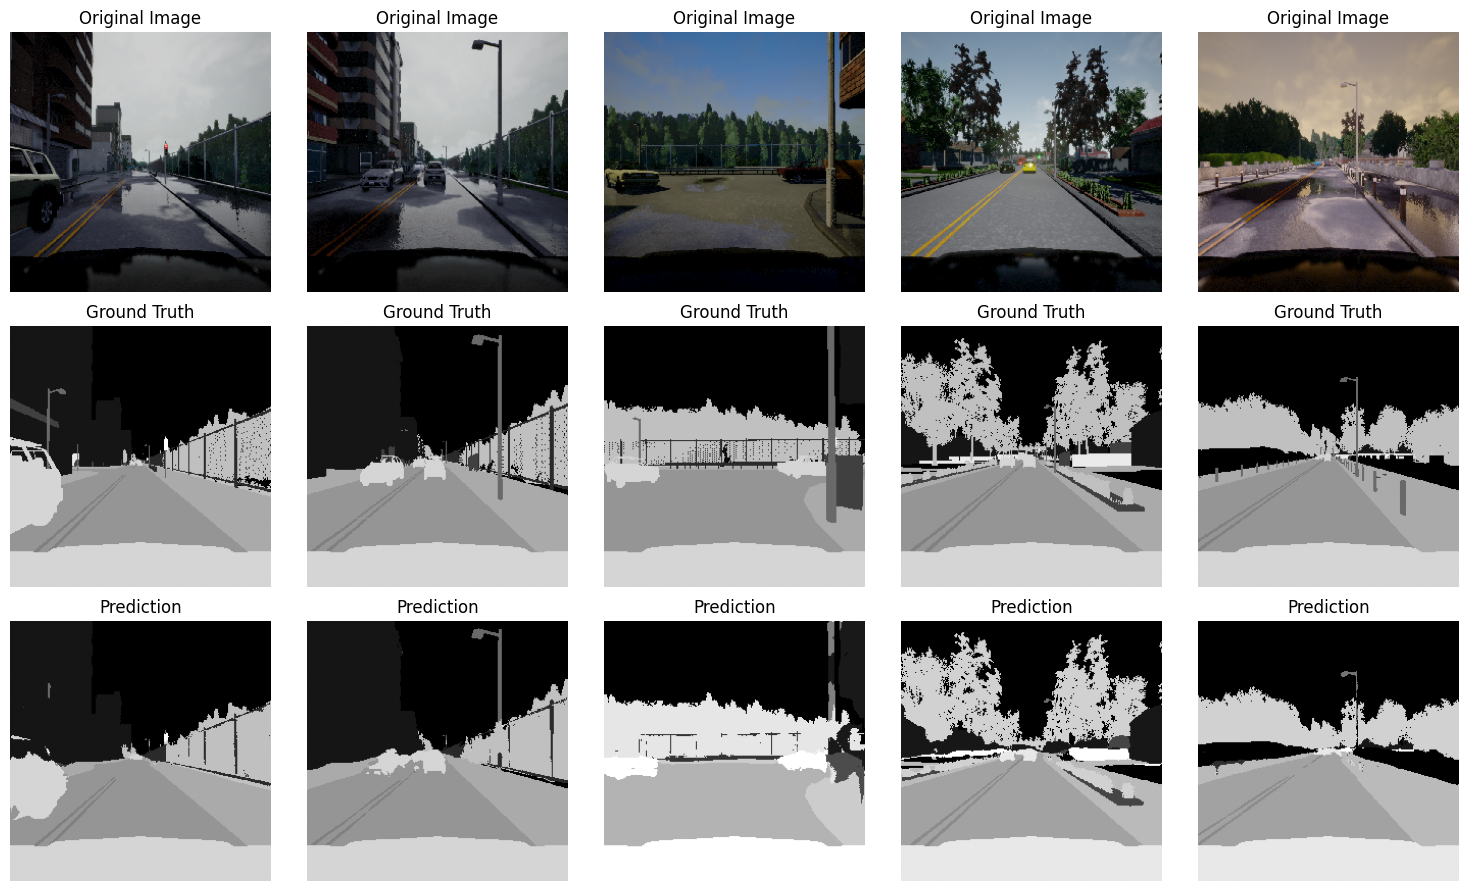

In [23]:
train_graphs(train_losses, train_mious, val_losses, val_mious)
model = VanillaUNet(13)
model.load_state_dict(best_model_state)
test(model, test_loader)
visualize_model_results(model, test_loader)

## U-Net without Skip connections

In [24]:
model = NoSkipUNet(13)
train_losses, train_mious, val_losses, val_mious, best_model_state = train(model, train_loader, val_loader, 50)
torch.save(model.state_dict(), "no_skip_unet.pth")

Epoch 1/50


Train Loss: 1.9325, Train mIoU: 0.0916, Val Loss: 1.5407, Val mIoU: 0.1416
Epoch 2/50


Train Loss: 1.2668, Train mIoU: 0.2627, Val Loss: 1.0289, Val mIoU: 0.3670
Epoch 3/50


Train Loss: 0.8499, Train mIoU: 0.4956, Val Loss: 0.7392, Val mIoU: 0.5524
Epoch 4/50


Train Loss: 0.6772, Train mIoU: 0.5695, Val Loss: 0.6513, Val mIoU: 0.5945
Epoch 5/50


Train Loss: 0.6080, Train mIoU: 0.5980, Val Loss: 0.5797, Val mIoU: 0.6125
Epoch 6/50


Train Loss: 0.5423, Train mIoU: 0.6358, Val Loss: 0.5234, Val mIoU: 0.6482
Epoch 7/50


Train Loss: 0.5100, Train mIoU: 0.6531, Val Loss: 0.5131, Val mIoU: 0.6536
Epoch 8/50


Train Loss: 0.4708, Train mIoU: 0.6722, Val Loss: 0.4477, Val mIoU: 0.6884
Epoch 9/50


Train Loss: 0.4383, Train mIoU: 0.6853, Val Loss: 0.4294, Val mIoU: 0.6928
Epoch 10/50


Train Loss: 0.4150, Train mIoU: 0.6949, Val Loss: 0.4493, Val mIoU: 0.6788
Epoch 11/50


Train Loss: 0.3973, Train mIoU: 0.7029, Val Loss: 0.3823, Val mIoU: 0.7120
Epoch 12/50


Train Loss: 0.3743, Train mIoU: 0.7128, Val Loss: 0.3611, Val mIoU: 0.7222
Epoch 13/50


Train Loss: 0.3633, Train mIoU: 0.7169, Val Loss: 0.3499, Val mIoU: 0.7293
Epoch 14/50


Train Loss: 0.3449, Train mIoU: 0.7247, Val Loss: 0.3384, Val mIoU: 0.7324
Epoch 15/50


Train Loss: 0.3273, Train mIoU: 0.7338, Val Loss: 0.3218, Val mIoU: 0.7437
Epoch 16/50


Train Loss: 0.3145, Train mIoU: 0.7394, Val Loss: 0.3161, Val mIoU: 0.7504
Epoch 17/50


Train Loss: 0.3007, Train mIoU: 0.7456, Val Loss: 0.3028, Val mIoU: 0.7491
Epoch 18/50


Train Loss: 0.2926, Train mIoU: 0.7489, Val Loss: 0.2939, Val mIoU: 0.7545
Epoch 19/50


Train Loss: 0.2942, Train mIoU: 0.7471, Val Loss: 0.3446, Val mIoU: 0.7408
Epoch 20/50


Train Loss: 0.2835, Train mIoU: 0.7536, Val Loss: 0.2779, Val mIoU: 0.7601
Epoch 21/50


Train Loss: 0.2644, Train mIoU: 0.7624, Val Loss: 0.2665, Val mIoU: 0.7682
Epoch 22/50


Train Loss: 0.2581, Train mIoU: 0.7647, Val Loss: 0.2622, Val mIoU: 0.7704
Epoch 23/50


Train Loss: 0.2497, Train mIoU: 0.7686, Val Loss: 0.2627, Val mIoU: 0.7604
Epoch 24/50


Train Loss: 0.2443, Train mIoU: 0.7702, Val Loss: 0.2547, Val mIoU: 0.7702
Epoch 25/50


Train Loss: 0.2382, Train mIoU: 0.7731, Val Loss: 0.2401, Val mIoU: 0.7786
Epoch 26/50


Train Loss: 0.2323, Train mIoU: 0.7759, Val Loss: 0.2459, Val mIoU: 0.7684
Epoch 27/50


Train Loss: 0.2263, Train mIoU: 0.7782, Val Loss: 0.2348, Val mIoU: 0.7791
Epoch 28/50


Train Loss: 0.2197, Train mIoU: 0.7811, Val Loss: 0.2311, Val mIoU: 0.7858
Epoch 29/50


Train Loss: 0.2153, Train mIoU: 0.7835, Val Loss: 0.2252, Val mIoU: 0.7855
Epoch 30/50


Train Loss: 0.2079, Train mIoU: 0.7871, Val Loss: 0.2218, Val mIoU: 0.7879
Epoch 31/50


Train Loss: 0.2061, Train mIoU: 0.7877, Val Loss: 0.2166, Val mIoU: 0.7846
Epoch 32/50


Train Loss: 0.2049, Train mIoU: 0.7876, Val Loss: 0.2115, Val mIoU: 0.7923
Epoch 33/50


Train Loss: 0.1974, Train mIoU: 0.7921, Val Loss: 0.2093, Val mIoU: 0.7914
Epoch 34/50


Train Loss: 0.1908, Train mIoU: 0.7953, Val Loss: 0.2075, Val mIoU: 0.7919
Epoch 35/50


Train Loss: 0.1892, Train mIoU: 0.7958, Val Loss: 0.2041, Val mIoU: 0.7970
Epoch 36/50


Train Loss: 0.1832, Train mIoU: 0.7991, Val Loss: 0.1993, Val mIoU: 0.7957
Epoch 37/50


Train Loss: 0.1819, Train mIoU: 0.7996, Val Loss: 0.2012, Val mIoU: 0.7973
Epoch 38/50


Train Loss: 0.1777, Train mIoU: 0.8018, Val Loss: 0.1930, Val mIoU: 0.8010
Epoch 39/50


Train Loss: 0.1736, Train mIoU: 0.8038, Val Loss: 0.1927, Val mIoU: 0.7966
Epoch 40/50


Train Loss: 0.1698, Train mIoU: 0.8060, Val Loss: 0.1944, Val mIoU: 0.7970
Epoch 41/50


Train Loss: 0.1702, Train mIoU: 0.8051, Val Loss: 0.1881, Val mIoU: 0.8004
Epoch 42/50


Train Loss: 0.1639, Train mIoU: 0.8090, Val Loss: 0.1850, Val mIoU: 0.8054
Epoch 43/50


Train Loss: 0.1609, Train mIoU: 0.8107, Val Loss: 0.1835, Val mIoU: 0.8072
Epoch 44/50


Train Loss: 0.1583, Train mIoU: 0.8119, Val Loss: 0.1805, Val mIoU: 0.8063
Epoch 45/50


Train Loss: 0.1560, Train mIoU: 0.8131, Val Loss: 0.1797, Val mIoU: 0.8074
Epoch 46/50


Train Loss: 0.1528, Train mIoU: 0.8149, Val Loss: 0.1776, Val mIoU: 0.8085
Epoch 47/50


Train Loss: 0.1502, Train mIoU: 0.8164, Val Loss: 0.1771, Val mIoU: 0.8081
Epoch 48/50


Train Loss: 0.1491, Train mIoU: 0.8168, Val Loss: 0.1784, Val mIoU: 0.8073
Epoch 49/50


Train Loss: 0.1478, Train mIoU: 0.8176, Val Loss: 0.1744, Val mIoU: 0.8107
Epoch 50/50


Train Loss: 0.1440, Train mIoU: 0.8196, Val Loss: 0.1726, Val mIoU: 0.8116


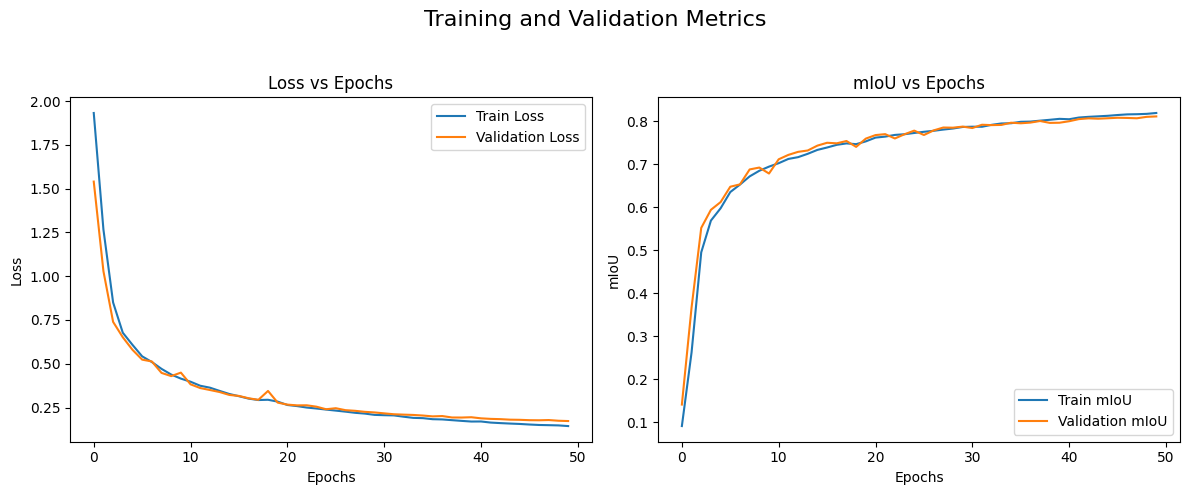

Test mIoU: 0.8045


In [25]:
train_graphs(train_losses, train_mious, val_losses, val_mious)
model = NoSkipUNet(13)
model.load_state_dict(best_model_state)
test(model, test_loader)
visualize_model_results(model, test_loader)

## Residual U-Net

In [26]:
model = ResidualUNet(13)
train_losses, train_mious, val_losses, val_mious, best_model_state = train(model, train_loader, val_loader, 50)
torch.save(model.state_dict(), "residual_unet.pth")

Epoch 1/50


Train Loss: 1.7154, Train mIoU: 0.2935, Val Loss: 1.1537, Val mIoU: 0.5032
Epoch 2/50


Train Loss: 0.9229, Train mIoU: 0.5469, Val Loss: 0.7618, Val mIoU: 0.5924
Epoch 3/50


Train Loss: 0.6618, Train mIoU: 0.6220, Val Loss: 0.6081, Val mIoU: 0.6457
Epoch 4/50


Train Loss: 0.5565, Train mIoU: 0.6523, Val Loss: 0.5185, Val mIoU: 0.6781
Epoch 5/50


Train Loss: 0.5014, Train mIoU: 0.6756, Val Loss: 0.4607, Val mIoU: 0.7051
Epoch 6/50


Train Loss: 0.4314, Train mIoU: 0.7136, Val Loss: 0.4210, Val mIoU: 0.7214
Epoch 7/50


Train Loss: 0.3759, Train mIoU: 0.7405, Val Loss: 0.3538, Val mIoU: 0.7526
Epoch 8/50


Train Loss: 0.3524, Train mIoU: 0.7500, Val Loss: 0.3279, Val mIoU: 0.7652
Epoch 9/50


Train Loss: 0.3136, Train mIoU: 0.7689, Val Loss: 0.3018, Val mIoU: 0.7764
Epoch 10/50


Train Loss: 0.2906, Train mIoU: 0.7782, Val Loss: 0.2811, Val mIoU: 0.7859
Epoch 11/50


Train Loss: 0.2714, Train mIoU: 0.7856, Val Loss: 0.2633, Val mIoU: 0.7940
Epoch 12/50


Train Loss: 0.2552, Train mIoU: 0.7915, Val Loss: 0.2475, Val mIoU: 0.7980
Epoch 13/50


Train Loss: 0.2402, Train mIoU: 0.7968, Val Loss: 0.2392, Val mIoU: 0.8023
Epoch 14/50


Train Loss: 0.2312, Train mIoU: 0.7997, Val Loss: 0.2228, Val mIoU: 0.8083
Epoch 15/50


Train Loss: 0.2093, Train mIoU: 0.8103, Val Loss: 0.2096, Val mIoU: 0.8126
Epoch 16/50


Train Loss: 0.2023, Train mIoU: 0.8132, Val Loss: 0.2057, Val mIoU: 0.8179
Epoch 17/50


Train Loss: 0.1920, Train mIoU: 0.8179, Val Loss: 0.1903, Val mIoU: 0.8215
Epoch 18/50


Train Loss: 0.1817, Train mIoU: 0.8218, Val Loss: 0.1857, Val mIoU: 0.8258
Epoch 19/50


Train Loss: 0.1721, Train mIoU: 0.8270, Val Loss: 0.1728, Val mIoU: 0.8309
Epoch 20/50


Train Loss: 0.1673, Train mIoU: 0.8295, Val Loss: 0.1706, Val mIoU: 0.8341
Epoch 21/50


Train Loss: 0.1601, Train mIoU: 0.8334, Val Loss: 0.1622, Val mIoU: 0.8386
Epoch 22/50


Train Loss: 0.1518, Train mIoU: 0.8386, Val Loss: 0.1552, Val mIoU: 0.8438
Epoch 23/50


Train Loss: 0.1478, Train mIoU: 0.8411, Val Loss: 0.1545, Val mIoU: 0.8434
Epoch 24/50


Train Loss: 0.1410, Train mIoU: 0.8459, Val Loss: 0.1497, Val mIoU: 0.8473
Epoch 25/50


Train Loss: 0.1359, Train mIoU: 0.8498, Val Loss: 0.1413, Val mIoU: 0.8547
Epoch 26/50


Train Loss: 0.1320, Train mIoU: 0.8532, Val Loss: 0.1395, Val mIoU: 0.8563
Epoch 27/50


Train Loss: 0.1270, Train mIoU: 0.8565, Val Loss: 0.1361, Val mIoU: 0.8599
Epoch 28/50


Train Loss: 0.1266, Train mIoU: 0.8571, Val Loss: 0.1338, Val mIoU: 0.8614
Epoch 29/50


Train Loss: 0.1214, Train mIoU: 0.8609, Val Loss: 0.1288, Val mIoU: 0.8627
Epoch 30/50


Train Loss: 0.1163, Train mIoU: 0.8635, Val Loss: 0.1271, Val mIoU: 0.8644
Epoch 31/50


Train Loss: 0.1132, Train mIoU: 0.8655, Val Loss: 0.1257, Val mIoU: 0.8662
Epoch 32/50


Train Loss: 0.1120, Train mIoU: 0.8665, Val Loss: 0.1232, Val mIoU: 0.8674
Epoch 33/50


Train Loss: 0.1077, Train mIoU: 0.8695, Val Loss: 0.1201, Val mIoU: 0.8690
Epoch 34/50


Train Loss: 0.1048, Train mIoU: 0.8710, Val Loss: 0.1177, Val mIoU: 0.8699
Epoch 35/50


Train Loss: 0.1023, Train mIoU: 0.8727, Val Loss: 0.1129, Val mIoU: 0.8726
Epoch 36/50


Train Loss: 0.0995, Train mIoU: 0.8743, Val Loss: 0.1164, Val mIoU: 0.8709
Epoch 37/50


Train Loss: 0.1021, Train mIoU: 0.8727, Val Loss: 0.1117, Val mIoU: 0.8741
Epoch 38/50


Train Loss: 0.0994, Train mIoU: 0.8743, Val Loss: 0.1107, Val mIoU: 0.8748
Epoch 39/50


Train Loss: 0.0931, Train mIoU: 0.8779, Val Loss: 0.1088, Val mIoU: 0.8759
Epoch 40/50


Train Loss: 0.0921, Train mIoU: 0.8785, Val Loss: 0.1077, Val mIoU: 0.8762
Epoch 41/50


Train Loss: 0.0923, Train mIoU: 0.8785, Val Loss: 0.1044, Val mIoU: 0.8782
Epoch 42/50


Train Loss: 0.0897, Train mIoU: 0.8801, Val Loss: 0.1038, Val mIoU: 0.8781
Epoch 43/50


Train Loss: 0.0872, Train mIoU: 0.8815, Val Loss: 0.1020, Val mIoU: 0.8785
Epoch 44/50


Train Loss: 0.0867, Train mIoU: 0.8818, Val Loss: 0.1041, Val mIoU: 0.8799
Epoch 45/50


Train Loss: 0.0859, Train mIoU: 0.8821, Val Loss: 0.1006, Val mIoU: 0.8789
Epoch 46/50


Train Loss: 0.0835, Train mIoU: 0.8836, Val Loss: 0.1016, Val mIoU: 0.8788
Epoch 47/50


Train Loss: 0.0822, Train mIoU: 0.8843, Val Loss: 0.0990, Val mIoU: 0.8823
Epoch 48/50


Train Loss: 0.0808, Train mIoU: 0.8851, Val Loss: 0.0982, Val mIoU: 0.8812
Epoch 49/50


Train Loss: 0.0800, Train mIoU: 0.8858, Val Loss: 0.0963, Val mIoU: 0.8829
Epoch 50/50


Train Loss: 0.0788, Train mIoU: 0.8862, Val Loss: 0.0989, Val mIoU: 0.8817


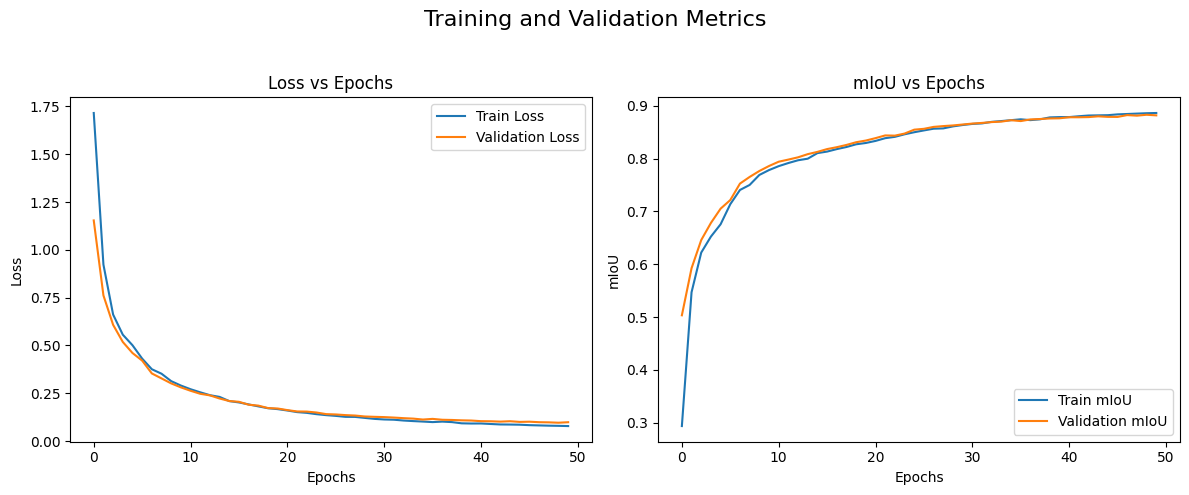

Test mIoU: 0.8763


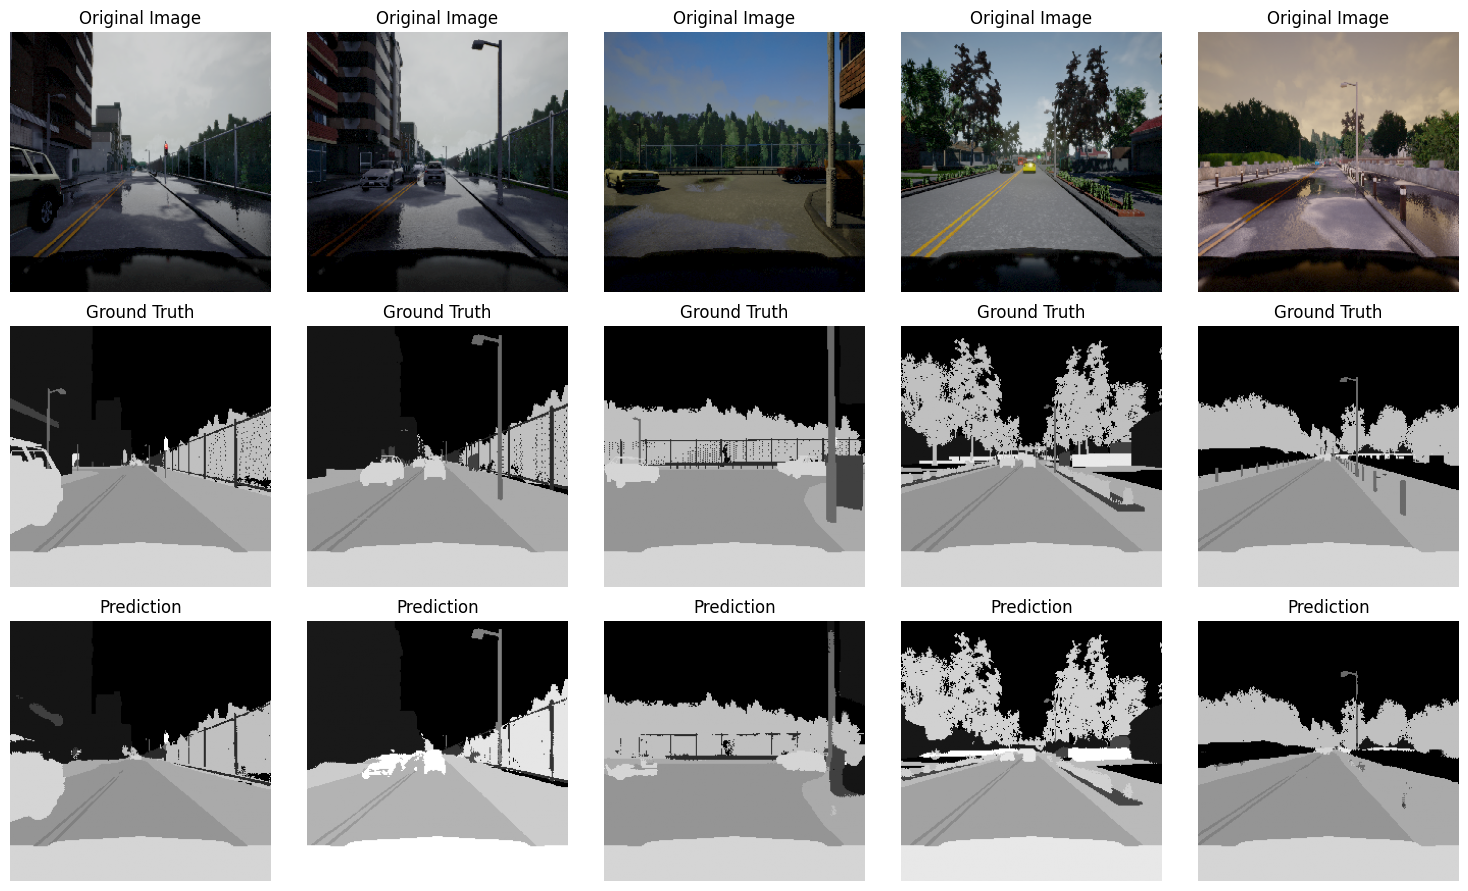

In [27]:
train_graphs(train_losses, train_mious, val_losses, val_mious)
model = ResidualUNet(13)
model.load_state_dict(best_model_state)
test(model, test_loader)
visualize_model_results(model, test_loader)

## Gated U-Net

In [28]:
model = GatedUNet(13)
train_losses, train_mious, val_losses, val_mious, best_model_state = train(model, train_loader, val_loader, 50)
torch.save(model.state_dict(), "gated_unet.pth")

Epoch 1/50


Train Loss: 1.8457, Train mIoU: 0.2773, Val Loss: 1.3835, Val mIoU: 0.4096
Epoch 2/50


Train Loss: 1.1331, Train mIoU: 0.4706, Val Loss: 0.9834, Val mIoU: 0.5581
Epoch 3/50


Train Loss: 0.8742, Train mIoU: 0.5736, Val Loss: 0.7445, Val mIoU: 0.6138
Epoch 4/50


Train Loss: 0.6586, Train mIoU: 0.6265, Val Loss: 0.6180, Val mIoU: 0.6425
Epoch 5/50


Train Loss: 0.5774, Train mIoU: 0.6440, Val Loss: 0.5580, Val mIoU: 0.6594
Epoch 6/50


Train Loss: 0.5279, Train mIoU: 0.6557, Val Loss: 0.5219, Val mIoU: 0.6631
Epoch 7/50


Train Loss: 0.4727, Train mIoU: 0.6844, Val Loss: 0.4629, Val mIoU: 0.6863
Epoch 8/50


Train Loss: 0.4128, Train mIoU: 0.7151, Val Loss: 0.3871, Val mIoU: 0.7350
Epoch 9/50


Train Loss: 0.3576, Train mIoU: 0.7449, Val Loss: 0.3254, Val mIoU: 0.7647
Epoch 10/50


Train Loss: 0.3138, Train mIoU: 0.7662, Val Loss: 0.3035, Val mIoU: 0.7710
Epoch 11/50


Train Loss: 0.2913, Train mIoU: 0.7749, Val Loss: 0.2745, Val mIoU: 0.7841
Epoch 12/50


Train Loss: 0.2646, Train mIoU: 0.7863, Val Loss: 0.2716, Val mIoU: 0.7858
Epoch 13/50


Train Loss: 0.2475, Train mIoU: 0.7922, Val Loss: 0.2548, Val mIoU: 0.7945
Epoch 14/50


Train Loss: 0.2381, Train mIoU: 0.7958, Val Loss: 0.2372, Val mIoU: 0.8030
Epoch 15/50


Train Loss: 0.2233, Train mIoU: 0.8033, Val Loss: 0.2206, Val mIoU: 0.8075
Epoch 16/50


Train Loss: 0.2080, Train mIoU: 0.8087, Val Loss: 0.2088, Val mIoU: 0.8158
Epoch 17/50


Train Loss: 0.1979, Train mIoU: 0.8133, Val Loss: 0.2028, Val mIoU: 0.8174
Epoch 18/50


Train Loss: 0.1886, Train mIoU: 0.8175, Val Loss: 0.1930, Val mIoU: 0.8208
Epoch 19/50


Train Loss: 0.1815, Train mIoU: 0.8205, Val Loss: 0.1921, Val mIoU: 0.8213
Epoch 20/50


Train Loss: 0.1735, Train mIoU: 0.8240, Val Loss: 0.1790, Val mIoU: 0.8280
Epoch 21/50


Train Loss: 0.1657, Train mIoU: 0.8282, Val Loss: 0.1745, Val mIoU: 0.8308
Epoch 22/50


Train Loss: 0.1621, Train mIoU: 0.8302, Val Loss: 0.1708, Val mIoU: 0.8310
Epoch 23/50


Train Loss: 0.1546, Train mIoU: 0.8339, Val Loss: 0.1623, Val mIoU: 0.8361
Epoch 24/50


Train Loss: 0.1495, Train mIoU: 0.8366, Val Loss: 0.1613, Val mIoU: 0.8385
Epoch 25/50


Train Loss: 0.1467, Train mIoU: 0.8385, Val Loss: 0.1557, Val mIoU: 0.8401
Epoch 26/50


Train Loss: 0.1382, Train mIoU: 0.8442, Val Loss: 0.1460, Val mIoU: 0.8487
Epoch 27/50


Train Loss: 0.1336, Train mIoU: 0.8474, Val Loss: 0.1451, Val mIoU: 0.8494
Epoch 28/50


Train Loss: 0.1303, Train mIoU: 0.8503, Val Loss: 0.1413, Val mIoU: 0.8527
Epoch 29/50


Train Loss: 0.1262, Train mIoU: 0.8538, Val Loss: 0.1361, Val mIoU: 0.8578
Epoch 30/50


Train Loss: 0.1244, Train mIoU: 0.8562, Val Loss: 0.1433, Val mIoU: 0.8547
Epoch 31/50


Train Loss: 0.1223, Train mIoU: 0.8574, Val Loss: 0.1390, Val mIoU: 0.8598
Epoch 32/50


Train Loss: 0.1182, Train mIoU: 0.8605, Val Loss: 0.1285, Val mIoU: 0.8628
Epoch 33/50


Train Loss: 0.1137, Train mIoU: 0.8639, Val Loss: 0.1285, Val mIoU: 0.8636
Epoch 34/50


Train Loss: 0.1099, Train mIoU: 0.8666, Val Loss: 0.1218, Val mIoU: 0.8685
Epoch 35/50


Train Loss: 0.1081, Train mIoU: 0.8678, Val Loss: 0.1255, Val mIoU: 0.8671
Epoch 36/50


Train Loss: 0.1051, Train mIoU: 0.8700, Val Loss: 0.1222, Val mIoU: 0.8684
Epoch 37/50


Train Loss: 0.1025, Train mIoU: 0.8718, Val Loss: 0.1157, Val mIoU: 0.8721
Epoch 38/50


Train Loss: 0.0990, Train mIoU: 0.8738, Val Loss: 0.1143, Val mIoU: 0.8732
Epoch 39/50


Train Loss: 0.0980, Train mIoU: 0.8747, Val Loss: 0.1139, Val mIoU: 0.8733
Epoch 40/50


Train Loss: 0.0960, Train mIoU: 0.8759, Val Loss: 0.1140, Val mIoU: 0.8744
Epoch 41/50


Train Loss: 0.0944, Train mIoU: 0.8771, Val Loss: 0.1131, Val mIoU: 0.8754
Epoch 42/50


Train Loss: 0.0939, Train mIoU: 0.8774, Val Loss: 0.1124, Val mIoU: 0.8747
Epoch 43/50


Train Loss: 0.0918, Train mIoU: 0.8786, Val Loss: 0.1125, Val mIoU: 0.8763
Epoch 44/50


Train Loss: 0.0888, Train mIoU: 0.8807, Val Loss: 0.1056, Val mIoU: 0.8793
Epoch 45/50


Train Loss: 0.0861, Train mIoU: 0.8822, Val Loss: 0.1042, Val mIoU: 0.8803
Epoch 46/50


Train Loss: 0.0847, Train mIoU: 0.8830, Val Loss: 0.1036, Val mIoU: 0.8799
Epoch 47/50


Train Loss: 0.0840, Train mIoU: 0.8835, Val Loss: 0.1040, Val mIoU: 0.8792
Epoch 48/50


Train Loss: 0.0840, Train mIoU: 0.8835, Val Loss: 0.1018, Val mIoU: 0.8807
Epoch 49/50


Train Loss: 0.0821, Train mIoU: 0.8846, Val Loss: 0.1004, Val mIoU: 0.8821
Epoch 50/50


Train Loss: 0.0793, Train mIoU: 0.8862, Val Loss: 0.0981, Val mIoU: 0.8827


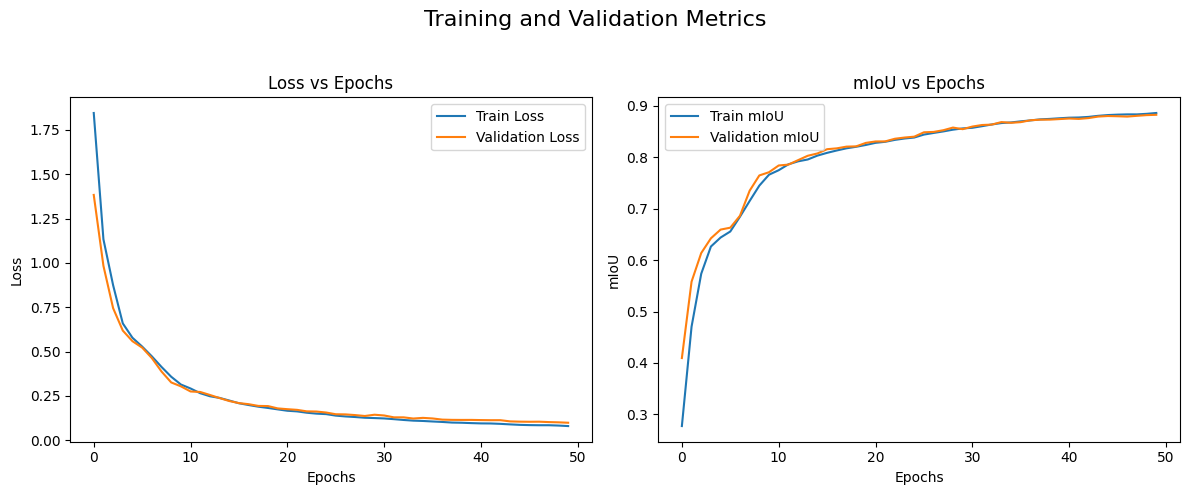

Test mIoU: 0.8756


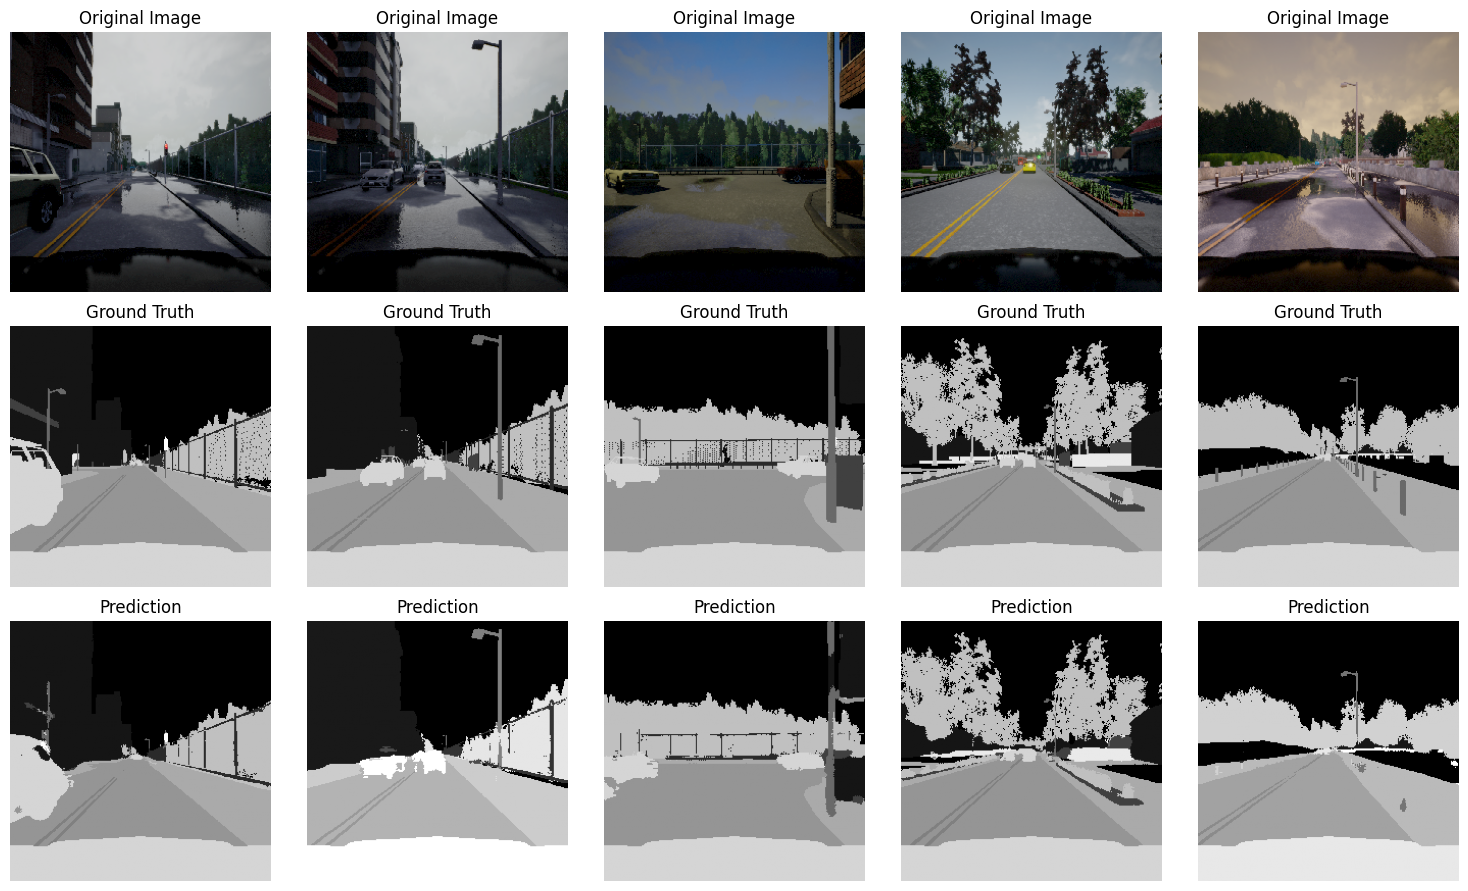

In [29]:
train_graphs(train_losses, train_mious, val_losses, val_mious)
model = GatedUNet(13)
model.load_state_dict(best_model_state)
test(model, test_loader)
visualize_model_results(model, test_loader)